# FineTune the XGboost!

- This is only a snapshot of the Finetune process as it is a iterative process (its a rabbit hole)



In [ ]:
!pip install \
    --extra-index-url=https://pypi.nvidia.com \
    cudf-cu12==24.2.* dask-cudf-cu12==24.2.* cuml-cu12==24.2.* \
    cugraph-cu12==24.2.* cuspatial-cu12==24.2.* cuproj-cu12==24.2.* \
    cuxfilter-cu12==24.2.* cucim-cu12==24.2.* pylibraft-cu12==24.2.* \
    raft-dask-cu12==24.2.*

In [ ]:
!pip install pandas 

In [ ]:
!pip install skforecast

In [ ]:
!pip install matplotlib

In [ ]:
!pip install xgboost

In [ ]:
!pip install torch==2.2.0 torchvision==0.17.0 torchaudio==2.2.0 --index-url https://download.pytorch.org/whl/cu121

In [ ]:
!pip install --extra-index-url=https://pypi.nvidia.com cudf-cu12

In [46]:
# Data processing
# ===============================
import pandas as pd
# Graphics
# ===============================
import matplotlib.pyplot as plt
# Modeling and Forecasting
# ===============================
from xgboost import XGBRegressor
# Preprocessing
# ===============================
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import bayesian_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from sklearn.metrics import mean_absolute_error
# GPU
# ================================
import torch
import psutil
import gc 

In [47]:
# Print informatbion abput the GPU and CPU
# ==============================================================================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

print(f"CPU RAM Free: {psutil.virtual_memory().available / 1024**3:.2f} GB")

Using device: cuda
NVIDIA GeForce RTX 3090
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
CPU RAM Free: 49.45 GB


In [48]:
# mute the warnings
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

In [49]:
!nvidia-smi

Tue Mar 12 13:32:38 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090        On  | 00000000:01:00.0 Off |                  N/A |
|  0%   37C    P8              22W / 300W |    370MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Loading the  ETTh1 dataset

In [3]:
path = "ETTh1.csv"
df = pd.read_csv(path)
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df.drop("Id", axis=1, inplace=True)
df = df.asfreq('H')
df = df.sort_index()
df.head()

,OT
date,
2016-07-01 00:00:00,30.531000
2016-07-01 01:00:00,27.787001
2016-07-01 02:00:00,27.787001
2016-07-01 03:00:00,25.044001
2016-07-01 04:00:00,21.948000


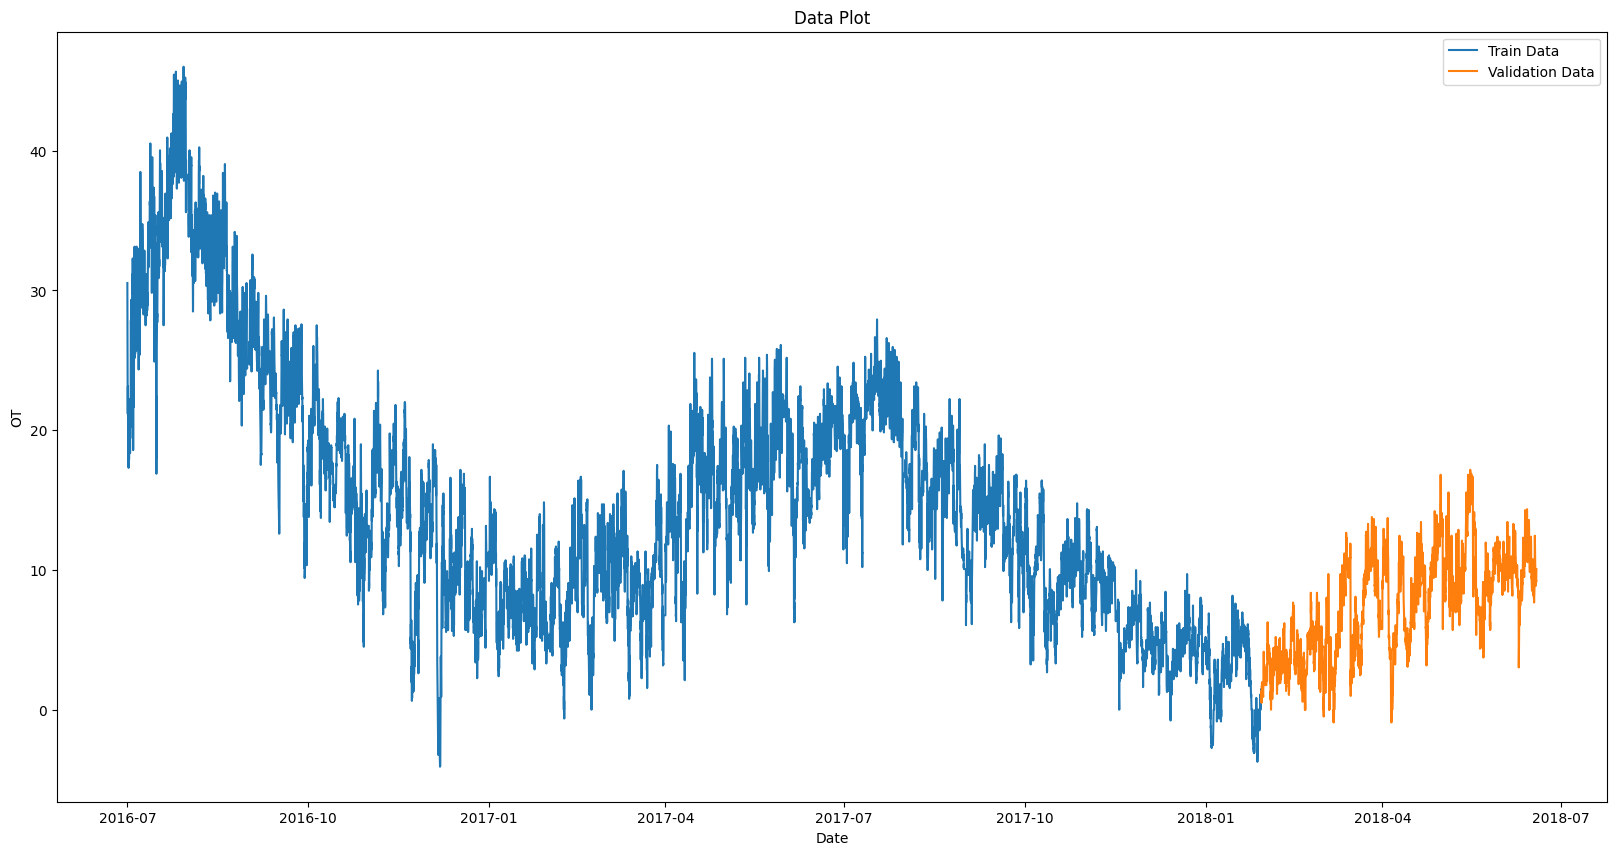

In [6]:
data = df.copy()
# Split data into train and test sets
train_size = int(len(data) * 0.8) # 80% train, 20 validation
train_val_data = data.iloc[:-100].copy()
train_data = data.iloc[:train_size].copy()
val_data = data.iloc[train_size:-100].copy()

plt.figure(figsize=(20, 10))
plt.plot(train_data, label='Train Data')
plt.plot(val_data, label='Validation Data')
plt.xlabel('Date')
plt.ylabel('OT')
plt.title('Data Plot')
plt.legend()
plt.show()

# XGboost Basic

I saved this cell to showcase the results of training a XGboost with default values:

In [13]:
# Create forecaster
forecaster = ForecasterAutoreg(
                 regressor = XGBRegressor(random_state=123,
                                          tree_method='hist',
                                          device='cuda'),
                 lags            = 24*30*6  )

# Fit model
import time
start_time = time.time()
forecaster.fit(y=train_data["OT"])
end_time = time.time()
print("Training Duration:", end_time - start_time, "seconds")
# Forecast test values
predictions = forecaster.predict(steps= len(val_data))
mae = mean_absolute_error(val_data["OT"], predictions)
print(f"Test error (MAE):{mae}")


Training Duration: 5.753171682357788 seconds
Test error (MAE):5.10995940177452


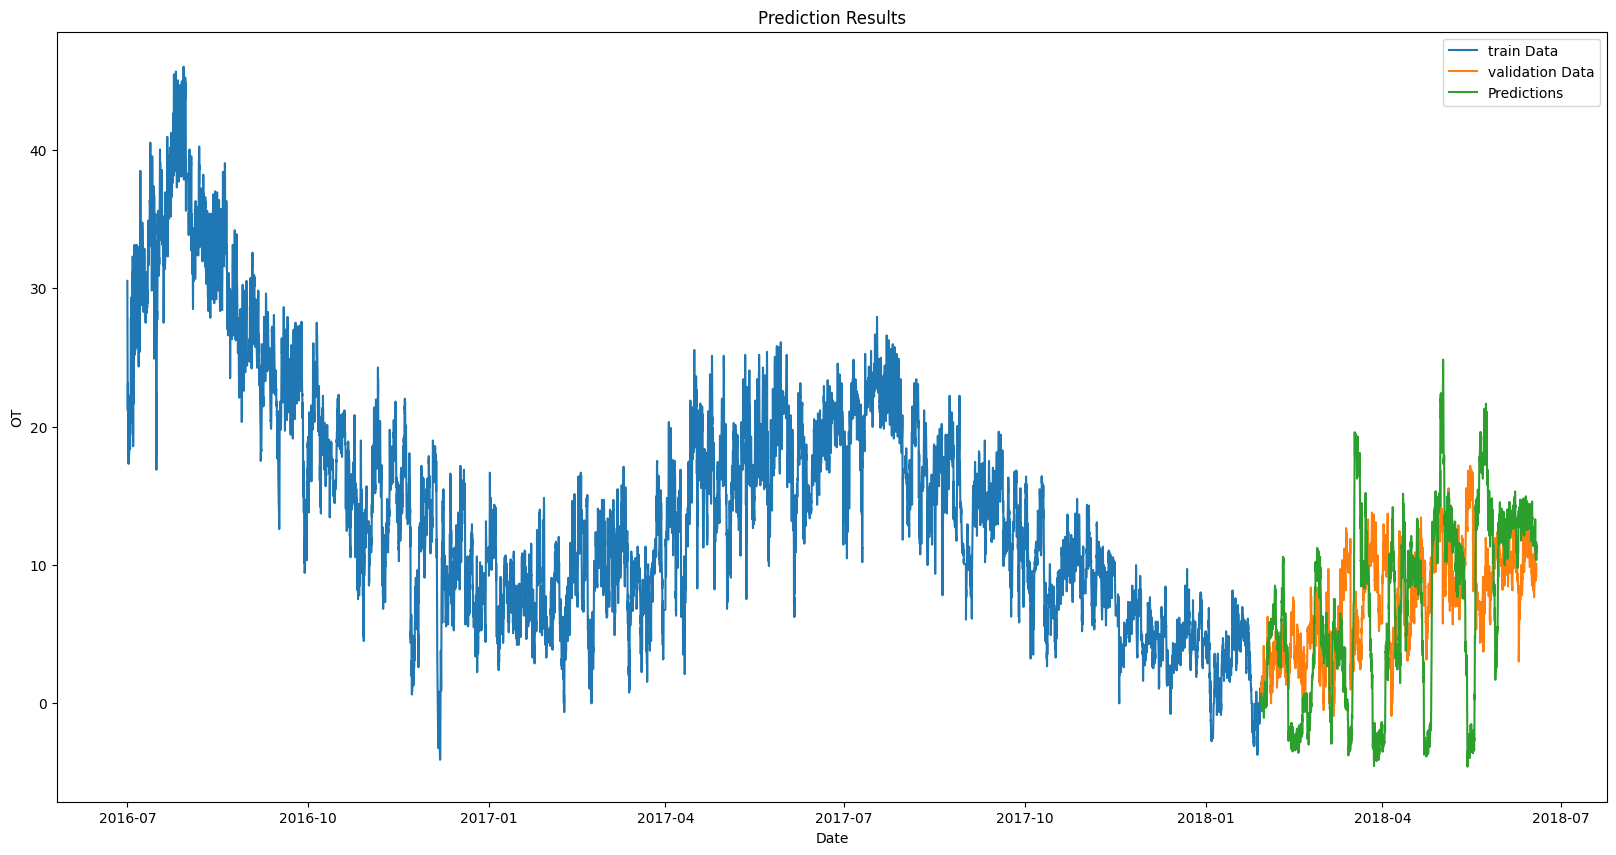

In [14]:
plt.figure(figsize=(20, 10))
plt.plot(train_data, label="train Data")
plt.plot(val_data, label='validation Data')
plt.plot(predictions, label='Predictions')
plt.xlabel('Date')
plt.ylabel('OT')
plt.title('Prediction Results')
plt.legend()
plt.show()

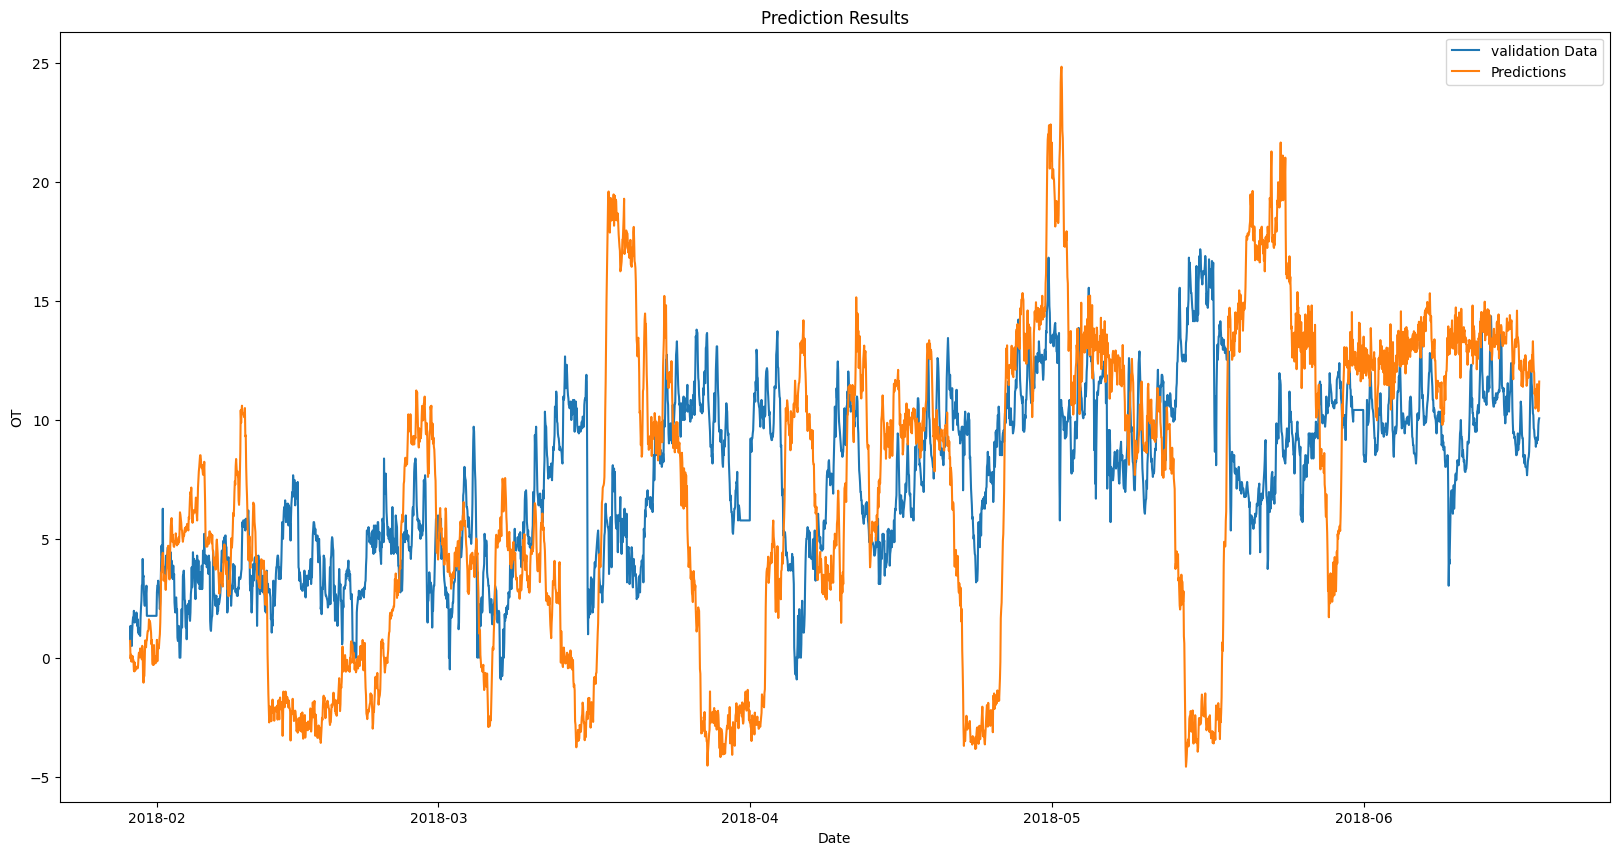

In [15]:
plt.figure(figsize=(20, 10))
plt.plot(val_data, label='validation Data')
plt.plot(predictions, label='Predictions')
plt.xlabel('Date')
plt.ylabel('OT')
plt.title('Prediction Results')
plt.legend()
plt.show()


## Fine tuning

Warning: It took 20-30min per lag configuration on a RTX3090TI. (2:30h total)

In [ ]:
# Lags grid
lags_grid = [24*30*3,24*30*4,24*30*5]

forecaster = ForecasterAutoreg(
                 regressor = XGBRegressor(random_state=123,
                                          tree_method='hist',
                                          device='cuda'),
                 lags            = 24*30*6  )

data = df.copy()

# Regressor hyperparameters search space
def search_space(trial):
    search_space  = {
        'n_estimators'  : trial.suggest_int('n_estimators', 200, 1200, step=100),
        'max_depth'     : trial.suggest_int('max_depth', 2, 14, step=1),
        'learning_rate' : trial.suggest_float('learning_rate', 0.01, 0.5),
        'reg_alpha'     : trial.suggest_float('reg_alpha', 0, 1, step=0.1),
        'reg_lambda'    : trial.suggest_float('reg_lambda', 0, 1, step=0.1),
    }
    return search_space

results_search, frozen_trial = bayesian_search_forecaster(
                                   forecaster         = forecaster,
                                   y                  = data["OT"], 
                                   search_space       = search_space,
                                   lags_grid          = lags_grid,
                                   steps              = 100,
                                   refit              = True, #Backtesting 
                                   metric             = 'mean_absolute_error',
                                   initial_train_size = len(train_data), # use only train part for training
                                   fixed_train_size   = False,
                                   n_trials           = 20, # Increase this value for a more exhaustive search
                                   random_state       = 123,
                                   return_best        = True,
                                   n_jobs             = -1,
                                   verbose            = False,
                                   show_progress      = True
                               )

Number of models compared: 60,
         20 bayesian search in each lag configuration.


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

In [18]:
results_search['lags'] = results_search['lags'].apply(lambda x: x[-1])
results_search.head(15)

,lags,params,mean_absolute_error,n_estimators,max_depth,learning_rate,reg_alpha,reg_lambda
33,2880,"{'n_estimators': 400, 'max_depth': 6, 'learnin...",2.002140,400.0,6.0,0.018067,0.2,0.2
19,2160,"{'n_estimators': 1000, 'max_depth': 5, 'learni...",2.332880,1000.0,5.0,0.013023,0.7,0.9
25,2880,"{'n_estimators': 600, 'max_depth': 6, 'learnin...",2.338737,600.0,6.0,0.121849,0.3,0.6
39,2880,"{'n_estimators': 400, 'max_depth': 6, 'learnin...",2.362934,400.0,6.0,0.052341,0.2,0.2
30,2880,"{'n_estimators': 1200, 'max_depth': 9, 'learni...",2.377582,1200.0,9.0,0.038865,0.1,0.0
12,2160,"{'n_estimators': 400, 'max_depth': 6, 'learnin...",2.462673,400.0,6.0,0.021575,0.8,1.0
31,2880,"{'n_estimators': 1200, 'max_depth': 9, 'learni...",2.505949,1200.0,9.0,0.071627,0.1,0.0
35,2880,"{'n_estimators': 500, 'max_depth': 6, 'learnin...",2.575631,500.0,6.0,0.013309,0.8,0.9
20,2880,"{'n_estimators': 1000, 'max_depth': 5, 'learni...",2.616382,1000.0,5.0,0.121157,0.6,0.7
14,2160,"{'n_estimators': 1000, 'max_depth': 5, 'learni...",2.634863,1000.0,5.0,0.022939,0.7,1.0


#### it seems that 2880 (4Months) and 2160(3months) are the best lag values.

other hyperparametrs are also important, but they tend to compensate each other (high n_estimators + low max depth = low n_estimators + high max depth) (not really but you can imagine it like this)

#### We are going to save all the models with their forecasting results (our goal is to get the best mea test result, and not necessarily the best model :p)After Submitting few times, it seems that the best models in validation aren't necessarily the best for the test set, why?:

- limitation on the data needed to make a very good accurate short duration forecasting (external factors, were already discussed)
- the test set may be just bad (random things to OT happened in the future 100hour)
- randomness, maybe the 10top ten validation models were all able to catch the general trend .. and one of them just happened to fit better the test set


#### To solve this problem (our goal is to get the best mea test result, and not necessarily the best model :p), We need to submit and test our best validation models and hope one of them does do really well on the test set!

In [19]:
results_search.to_csv("results_val.csv")

# Forcasting



In [21]:
predictions_list = []
i = 0
for index, row in results_search.iterrows():
    # Init Xgboost
    forecaster = ForecasterAutoreg(
                 regressor = XGBRegressor(random_state=123,
                                          tree_method='hist',
                                          device='cuda', learning_rate= row["learning_rate"],
                                          max_depth	= int(row["max_depth"]), n_estimators = int(row["n_estimators"]),
                                          reg_alpha= row["reg_alpha"], 	reg_lambda = row["reg_lambda"]),
                 lags            = row["lags"]  )
    
    forecaster.fit(data["OT"])
    predictions = forecaster.predict(100)
    predictions_list.append(predictions)
    print(f"finished forcasting with model number {i+1}/{len(results_search)}")
    # Empty GPU every 10 iterations
    if i%10 == 0:
        torch.cuda.empty_cache()
        gc.collect()
    i += 1
        
    
    

finished forcasting with model number 2/100
finished forcasting with model number 3/100
finished forcasting with model number 4/100
finished forcasting with model number 5/100
finished forcasting with model number 6/100
finished forcasting with model number 7/100
finished forcasting with model number 8/100
finished forcasting with model number 9/100
finished forcasting with model number 10/100
finished forcasting with model number 11/100
finished forcasting with model number 12/100
finished forcasting with model number 13/100
finished forcasting with model number 14/100
finished forcasting with model number 15/100
finished forcasting with model number 16/100
finished forcasting with model number 17/100
finished forcasting with model number 18/100
finished forcasting with model number 19/100
finished forcasting with model number 20/100
finished forcasting with model number 21/100
finished forcasting with model number 22/100
finished forcasting with model number 23/100
finished forcastin

lets save our predictions in a single csv file to upload them in kaggel

In [30]:
data = {f"prediction_{i}": pred for i, pred in enumerate(predictions_list)}

# Create a DataFrame from the dictionary
df = pd.DataFrame(data)
df

,prediction_0,prediction_1,prediction_2,prediction_3,prediction_4,prediction_5,prediction_6,prediction_7,prediction_8,prediction_9,...,prediction_90,prediction_91,prediction_92,prediction_93,prediction_94,prediction_95,prediction_96,prediction_97,prediction_98,prediction_99
2018-06-22 16:00:00,4.947838,4.852943,5.238245,4.857657,5.353516,4.946300,5.234301,5.125217,5.336321,4.907209,...,5.568582,5.226562,4.734245,4.961135,4.837832,5.129773,4.880085,5.511771,4.731511,4.798337
2018-06-22 17:00:00,5.233209,5.193844,5.549806,5.161375,6.162527,5.355485,5.995169,5.435957,5.466472,5.252015,...,6.351908,6.028309,5.548910,5.138062,5.707940,5.687540,5.520923,5.889598,5.097386,4.992585
2018-06-22 18:00:00,5.476543,5.425589,5.699322,5.402669,6.095879,5.714764,6.168704,5.649658,5.503748,5.441299,...,6.252003,6.560459,5.806316,5.371035,5.635878,6.386398,5.805265,5.574925,5.437898,5.020403
2018-06-22 19:00:00,5.591209,5.543186,5.733863,5.507956,6.150223,5.968420,6.244469,5.802674,5.526151,5.639707,...,6.013790,7.014187,6.095566,5.433439,5.172157,5.655069,6.111059,5.595644,5.570008,5.137322
2018-06-22 20:00:00,5.646990,5.616669,5.698115,5.632261,6.201144,5.980950,6.255647,5.945760,5.676049,5.863842,...,6.037100,6.039953,6.301344,5.485081,5.205223,6.201623,6.309382,5.502234,5.867984,5.269219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-06-26 15:00:00,9.182004,9.238318,9.500013,9.966330,7.106398,9.022466,7.406203,8.987367,8.676907,6.969929,...,6.381747,8.369797,8.836277,9.208110,9.144551,5.819770,8.843561,11.341237,4.238307,-0.477313
2018-06-26 16:00:00,9.141574,9.208874,9.591098,9.868360,7.274406,8.969049,7.585416,8.953668,8.597746,6.988924,...,6.338419,8.579955,8.295159,9.002219,9.240950,6.050898,8.728740,11.838277,4.489020,-0.489518
2018-06-26 17:00:00,9.063791,9.120690,9.534741,9.860552,7.253565,8.929012,7.605438,8.943226,8.612303,6.971786,...,6.396863,8.803525,8.167186,8.670176,9.306222,6.411948,8.615063,12.182593,4.681530,-0.359555
2018-06-26 18:00:00,8.885992,9.061430,9.474710,9.791483,7.165690,8.876760,7.846061,8.906913,8.681562,6.895015,...,6.453473,8.738404,7.836893,8.678465,8.968639,6.441580,8.482878,11.889621,4.556036,-0.366693


In [31]:
df.to_csv("predictions_all.csv")